In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    roc_auc_score, classification_report,
    precision_recall_curve
)
from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE


In [2]:
df = pd.read_csv(r"C:\Users\dell\OneDrive\Desktop\bank churn\resources\analytical_base_table.csv")  # replace with actual data path
X = df.drop(columns=['Exited'])
y = df['Exited']

# Split into train+val and test
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, stratify=y_temp, random_state=42)

# Define columns
scale_cols = ['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary']
cat_cols = ['Geography', 'Gender', 'HasCrCard', 'IsActiveMember', 'NumOfProducts']


In [3]:
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), scale_cols),
    ('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), cat_cols)
])


In [4]:
pipeline = ImbPipeline([
    ('preprocessor',preprocessor),
    ('model',RandomForestClassifier(class_weight='balanced'))
]
)

In [5]:
param_grid={
 'model__n_estimators' : [150,200,250],
 'model__min_samples_leaf' : [15,20,25],
 'model__min_samples_split' : [3, 4,5]
}

In [6]:
grid = GridSearchCV(
    estimator = pipeline,
    param_grid = param_grid,
    scoring = 'recall',
    cv=5,n_jobs=-1,verbose=1
)
grid.fit(X_train, y_train)
best_model = grid.best_estimator_
print("Best Params:", grid.best_params_)
print("Cross validation recall score" ,grid.best_score_)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best Params: {'model__min_samples_leaf': 25, 'model__min_samples_split': 5, 'model__n_estimators': 150}
Cross validation recall score 0.742348953728264


In [7]:
probs_val = best_model.predict_proba(X_val)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_val, probs_val)

f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)  # avoid div-by-zero
best_idx = np.argmax(f1_scores)
best_thresh = thresholds[best_idx]

print(f"Optimal Threshold (F1 max): {best_thresh:.4f}")


Optimal Threshold (F1 max): 0.6073


In [8]:
recall_cutoff = 0.75
valid_idxs = np.where(recall >= recall_cutoff)[0]

# Of those, pick the one with highest precision
best_idx_recall = valid_idxs[np.argmax(precision[valid_idxs])]
best_thresh_recall = thresholds[best_idx_recall]

print(f"Threshold for Recall ≥ 70%: {best_thresh_recall:.4f}")

Threshold for Recall ≥ 70%: 0.4796


In [9]:
probs_test = best_model.predict_proba(X_test)[:, 1]
y_pred_test_recall = (probs_test >= best_thresh_recall).astype(int)

print(f"ROC-AUC on Test: {roc_auc_score(y_test, probs_test):.4f}")
print("Classification using Recall score threshold")
print(classification_report(y_test, y_pred_test_recall))

ROC-AUC on Test: 0.8593
Classification using Recall score threshold
              precision    recall  f1-score   support

           0       0.93      0.79      0.85      1593
           1       0.48      0.77      0.59       407

    accuracy                           0.79      2000
   macro avg       0.71      0.78      0.72      2000
weighted avg       0.84      0.79      0.80      2000



In [10]:
probs_test = best_model.predict_proba(X_test)[:, 1]
y_pred_test = (probs_test >= best_thresh).astype(int)

print(f"ROC-AUC on Test: {roc_auc_score(y_test, probs_test):.4f}")
print("Classification using F1 score threshold")
print(classification_report(y_test, y_pred_test))


ROC-AUC on Test: 0.8593
Classification using F1 score threshold
              precision    recall  f1-score   support

           0       0.90      0.90      0.90      1593
           1       0.61      0.62      0.61       407

    accuracy                           0.84      2000
   macro avg       0.76      0.76      0.76      2000
weighted avg       0.84      0.84      0.84      2000



In [11]:
from joblib import dump

model_package = {
    'model':best_model,
    'threshold':best_thresh_recall
}
dump(model_package,'../models/rforest_model.pkl')

['../models/rforest_model.pkl']

In [12]:
best_thresh_recall

0.47955724324361076

In [13]:
probs_train = best_model.predict_proba(X_train)[:, 1]
probs_val   = best_model.predict_proba(X_val)[:, 1]
probs_test  = best_model.predict_proba(X_test)[:, 1]


In [14]:
y_train_pred = (probs_train >= best_thresh_recall).astype(int)
y_val_pred   = (probs_val >= best_thresh_recall).astype(int)
y_test_pred  = (probs_test >= best_thresh_recall).astype(int)


In [15]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate(y_true, y_pred, name):
    print(f"\n--- {name} ---")
    print("Accuracy :", accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred))
    print("Recall   :", recall_score(y_true, y_pred))
    print("F1 Score :", f1_score(y_true, y_pred))

evaluate(y_train, y_train_pred, "Train")
evaluate(y_val, y_val_pred, "Validation")
evaluate(y_test, y_test_pred, "Test")



--- Train ---
Accuracy : 0.8065625
Precision: 0.5160975609756098
Recall   : 0.8113496932515337
F1 Score : 0.6308884913536076

--- Validation ---
Accuracy : 0.784375
Precision: 0.481335952848723
Recall   : 0.7515337423312883
F1 Score : 0.5868263473053892

--- Test ---
Accuracy : 0.7855
Precision: 0.48297213622291024
Recall   : 0.7665847665847666
F1 Score : 0.5925925925925927


In [16]:
#hence no overfiiting

In [17]:
rf_model = best_model.named_steps['model']


,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
3006,747,France,Female,45,1,114959.12,1,1,0,189362.39
5735,585,Spain,Female,44,4,0.00,2,0,1,101728.46
5652,691,France,Female,29,9,0.00,2,0,0,199635.93
26,756,Germany,Male,36,2,136815.64,1,1,1,170041.95
3596,643,France,Male,36,0,148159.71,1,0,0,55835.66
...,...,...,...,...,...,...,...,...,...,...
3239,762,Spain,Female,19,6,0.00,2,1,0,55500.17
413,693,Germany,Female,41,9,181461.48,3,1,1,187929.43
5787,729,Germany,Male,26,4,97268.10,2,1,0,39356.38
860,667,France,Male,43,8,190227.46,1,1,0,97508.04


In [24]:
preprocessor_1 = best_model.named_steps['preprocessor']  # or whatever name you used


In [25]:
scale_cols = ['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary']
cat_cols = ['Geography', 'Gender', 'HasCrCard', 'IsActiveMember', 'NumOfProducts']


In [26]:
encoded_cat_names = preprocessor_1.named_transformers_['cat'].get_feature_names_out(cat_cols)
all_feature_names = np.concatenate([scale_cols, encoded_cat_names])

In [27]:
importances = rf_model.feature_importances_

In [28]:
feat_imp_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Display top features
print(feat_imp_df.head(10))

              Feature  Importance
1                 Age    0.326582
15    NumOfProducts_2    0.186600
3             Balance    0.088427
14    NumOfProducts_1    0.063835
6   Geography_Germany    0.047953
16    NumOfProducts_3    0.046614
12   IsActiveMember_0    0.043273
4     EstimatedSalary    0.039785
13   IsActiveMember_1    0.037200
0         CreditScore    0.036091


Age is by far the most influential factor — older customers likely have higher churn risk.

Number of Products (one-hot encoded) is critical. Customers with 2 products are more likely to churn compared to 1 or 3.

Balance and Estimated Salary show moderate influence, possibly linked to financial satisfaction.

IsActiveMember flags are important — inactive members (0) are more prone to churn.

Geography_Germany matters more than other regions (likely due to customer behavior patterns in that region).

Credit Score, while often assumed critical, is comparatively less important in your trained model.



In [29]:
# Take a small sample to speed things up
X_sample = X_train.sample(100, random_state=42)


In [31]:
best_pipeline = grid.best_estimator_

# Extract the preprocessing step
preprocessor = best_pipeline.named_steps['preprocessor']

# Extract the trained Random Forest model
rf_model = best_pipeline.named_steps['model']

In [32]:
X_transformed = preprocessor.transform(X_sample)

In [33]:
try:
    feature_names = preprocessor.get_feature_names_out()
except:
    feature_names = [f'feature_{i}' for i in range(X_transformed.shape[1])]

In [34]:
feature_names

array(['num__CreditScore', 'num__Age', 'num__Tenure', 'num__Balance',
       'num__EstimatedSalary', 'cat__Geography_France',
       'cat__Geography_Germany', 'cat__Geography_Spain',
       'cat__Gender_Female', 'cat__Gender_Male', 'cat__HasCrCard_0',
       'cat__HasCrCard_1', 'cat__IsActiveMember_0',
       'cat__IsActiveMember_1', 'cat__NumOfProducts_1',
       'cat__NumOfProducts_2', 'cat__NumOfProducts_3',
       'cat__NumOfProducts_4'], dtype=object)

In [35]:
import shap

# Use TreeExplainer since it's a Random Forest
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_transformed)


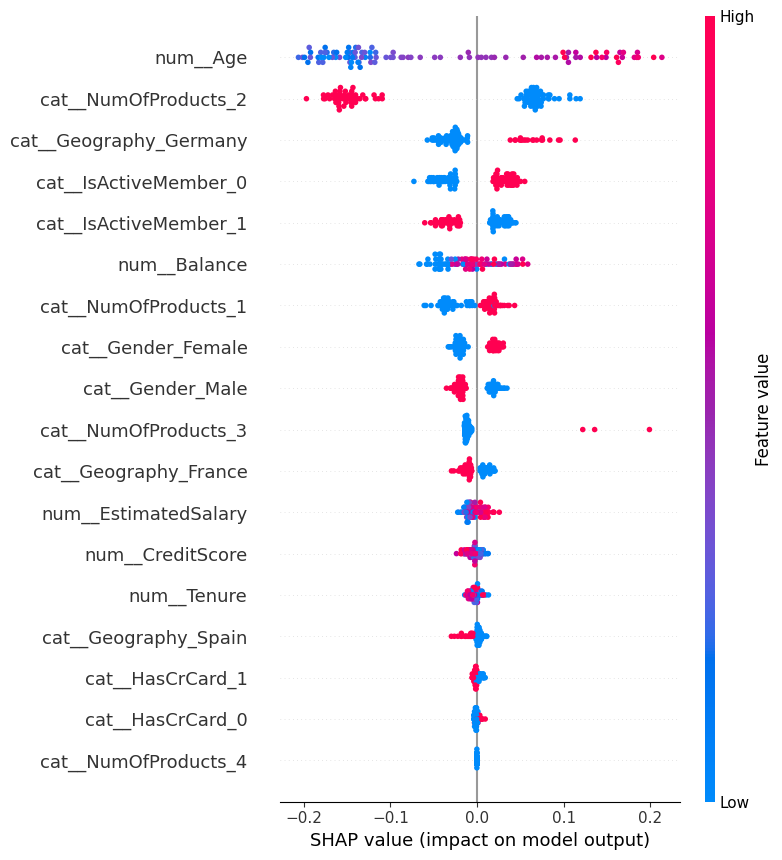

In [36]:
# Plot for the class = 1 (churned customers)
shap.summary_plot(shap_values[1], X_transformed, feature_names=feature_names)


| Feature                  | Description (based on SHAP plot) | Interpretation                                         |
| ------------------------ | -------------------------------- | ------------------------------------------------------ |
| `num__Age`               | Strongest feature                | **Older age → higher churn**                           |
| `cat__NumOfProducts_2`   | High impact                      | Having **2 products → lower churn** (red on left side) |
| `cat__Geography_Germany` | Strong churn indicator           | **German customers → higher churn**                    |
| `cat__IsActiveMember_0`  | Strong positive SHAP values      | **Not active → higher churn**                          |
| `num__Balance`           | Medium influence                 | Mixed — depends on combination with other features     |
| `cat__Gender_Female`     | Slight positive effect           | **Females → slightly higher churn**                    |
| `cat__NumOfProducts_1/3` | Moderate                         | Too few or too many products might signal churn risk   |
| `num__EstimatedSalary`   | Very weak influence              | Model doesn’t rely much on this                        |
